In [196]:
import warnings
warnings.filterwarnings('ignore')

In [302]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

from tqdm import tqdm

In [198]:
# !pip install --upgrade "statsmodels>=0.14"

In [199]:
plt.style.use('ggplot')

In [200]:
cpih = pd.read_csv('CPISHELT.csv')
cpih.head()

,observation_date,CUSR0000SAH1
0,1953-01-01,21.7
1,1953-02-01,21.8
2,1953-03-01,21.8
3,1953-04-01,21.9
4,1953-05-01,21.9


In [201]:
cpih = cpih.rename(
    {
        'CUSR0000SAH1': 'CPISHELT'
    }, axis=1
)

In [202]:
cpih['CPISHELT'] = cpih['CPISHELT'].astype(float)

In [203]:
cpih['CPISHELT_delta'] = cpih['CPISHELT'].diff()

In [204]:
cpih['CPISHELT_log'] = np.log(cpih['CPISHELT'])
cpih['CPISHELT_logdelta'] = cpih['CPISHELT_log'].diff()

In [205]:
cpih.head()

,observation_date,CPISHELT,CPISHELT_delta,CPISHELT_log,CPISHELT_logdelta
0,1953-01-01,21.7,NaN,3.077312,NaN
1,1953-02-01,21.8,0.1,3.081910,0.004598
2,1953-03-01,21.8,0.0,3.081910,0.000000
3,1953-04-01,21.9,0.1,3.086487,0.004577
4,1953-05-01,21.9,0.0,3.086487,0.000000


In [206]:
cpih

,observation_date,CPISHELT,CPISHELT_delta,CPISHELT_log,CPISHELT_logdelta
0,1953-01-01,21.700,NaN,3.077312,NaN
1,1953-02-01,21.800,0.100,3.081910,0.004598
2,1953-03-01,21.800,0.000,3.081910,0.000000
3,1953-04-01,21.900,0.100,3.086487,0.004577
4,1953-05-01,21.900,0.000,3.086487,0.000000
...,...,...,...,...,...
867,2025-04-01,413.103,1.379,6.023697,0.003344
868,2025-05-01,414.155,1.052,6.026240,0.002543
869,2025-06-01,414.883,0.728,6.027997,0.001756
870,2025-07-01,415.851,0.968,6.030327,0.002330


In [207]:
cpih['observation_date'] = pd.to_datetime(cpih['observation_date'])

In [208]:
cpih_rec = cpih[cpih['observation_date'] >= pd.to_datetime('2020-01-01')]
cpih_realrec = cpih[cpih['observation_date'] >= pd.to_datetime('2024-01-01')]

Text(0, 0.5, 'CPI for Urban Consumers - Housing')

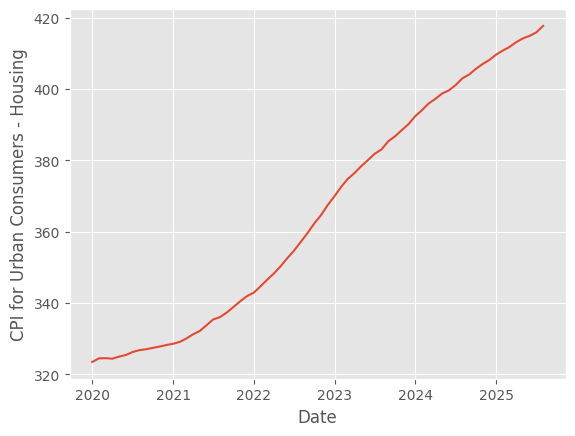

In [209]:
plt.plot(cpih_rec['observation_date'], cpih_rec['CPISHELT'])
plt.xlabel('Date')
plt.ylabel('CPI for Urban Consumers - Housing')

Text(0, 0.5, 'Monthly Change in CPISHELT')

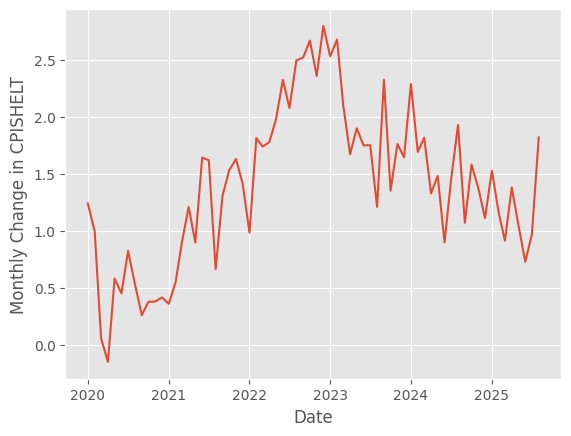

In [210]:
plt.plot(cpih_rec['observation_date'], cpih_rec['CPISHELT_delta'])
plt.xlabel('Date')
plt.ylabel('Monthly Change in CPISHELT')

In [312]:
adf_test = adfuller(cpih['CPISHELT_logdelta'][1:].values)
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -3.654678
p-value: 0.004798


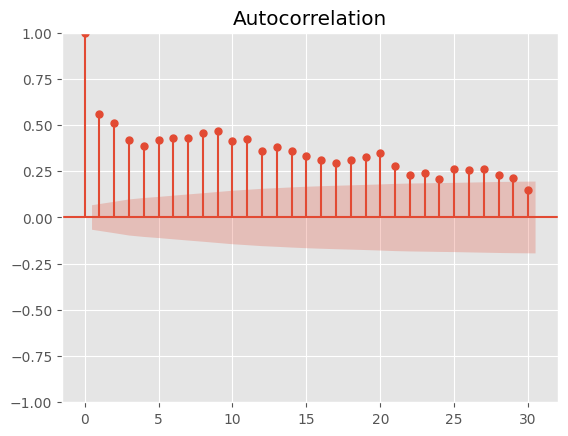

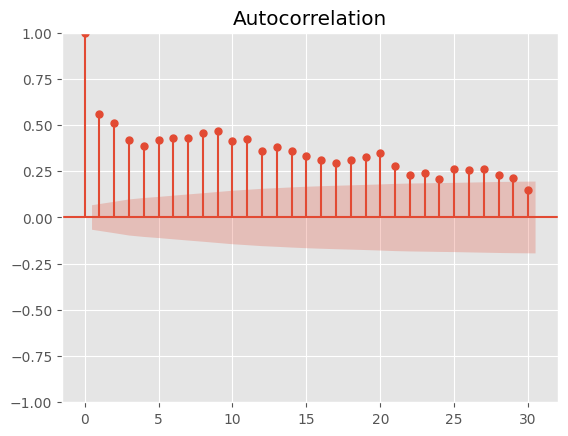

In [211]:
plot_acf(cpih['CPISHELT_logdelta'][1:])

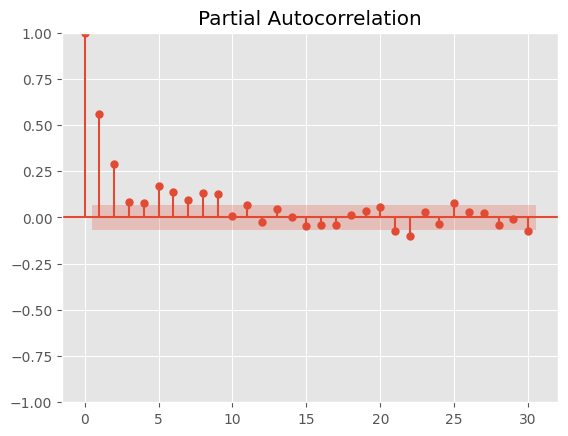

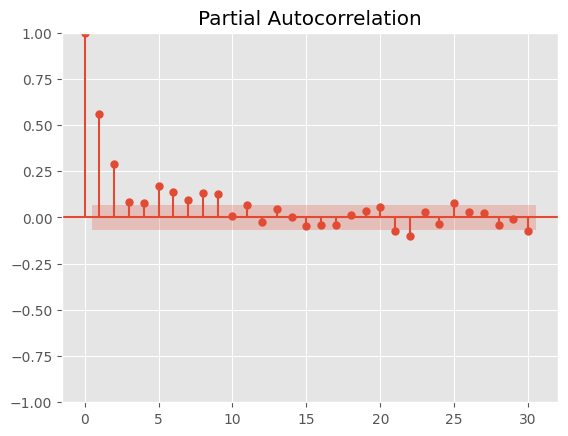

In [212]:
plot_pacf(cpih['CPISHELT_logdelta'][1:])

In [213]:
b = 15

In [214]:
end = cpih['CPISHELT_logdelta'][1:].values.shape[0] - b
end

856

In [215]:
p = 3
armod_sm = AutoReg(cpih['CPISHELT_logdelta'][1:end].values, lags = p).fit()
print(armod_sm.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  855
Model:                     AutoReg(3)   Log Likelihood                3821.589
Method:               Conditional MLE   S.D. of innovations              0.003
Date:                Sun, 14 Sep 2025   AIC                          -7633.179
Time:                        18:15:21   BIC                          -7609.441
Sample:                             3   HQIC                         -7624.087
                                  855                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      6.712      0.000       0.001       0.001
y.L1           0.3758      0.034     11.013      0.000       0.309       0.443
y.L2           0.2548      0.035      7.206      0.0

In [216]:
k, n_train = b + 1, cpih['CPISHELT_logdelta'][1:end].values.shape[0]
fcast = armod_sm.get_prediction(start = n_train, end = n_train + k - 1)
fcast_mean = fcast.predicted_mean
fcast_mean

array([0.00376246, 0.00362534, 0.00357364, 0.00355461, 0.00352265,
       0.0035014 , 0.00348366, 0.00346887, 0.00345698, 0.00344724,
       0.0034393 , 0.00343282, 0.00342754, 0.00342323, 0.00341971,
       0.00341684])

In [217]:
diffs_with_pred = np.append(cpih['CPISHELT_logdelta'][1:end].values, fcast_mean)
diffs_with_pred.shape

(871,)

In [218]:
pred_df = pd.DataFrame({'observation_date': cpih['observation_date'][1:], 'diffs': diffs_with_pred}).set_index(['observation_date'])
pred_df

,diffs
observation_date,
1953-02-01,0.004598
1953-03-01,0.000000
1953-04-01,0.004577
1953-05-01,0.000000
1953-06-01,0.000000
...,...
2025-04-01,0.003433
2025-05-01,0.003428
2025-06-01,0.003423


In [219]:
base = cpih['CPISHELT_log'].values[0]
pred_df['pred_logcpi'] = pred_df['diffs'].cumsum() + base

In [220]:
pred_df['diffs'][-10:]

observation_date
2024-11-01    0.003484
2024-12-01    0.003469
2025-01-01    0.003457
2025-02-01    0.003447
2025-03-01    0.003439
2025-04-01    0.003433
2025-05-01    0.003428
2025-06-01    0.003423
2025-07-01    0.003420
2025-08-01    0.003417
Name: diffs, dtype: float64

In [221]:
cpih[-10:]

,observation_date,CPISHELT,CPISHELT_delta,CPISHELT_log,CPISHELT_logdelta
862,2024-11-01,407.015,1.373,6.008850,0.003379
863,2024-12-01,408.126,1.111,6.011576,0.002726
864,2025-01-01,409.653,1.527,6.015310,0.003735
865,2025-02-01,410.811,1.158,6.018133,0.002823
866,2025-03-01,411.724,0.913,6.020353,0.002220
867,2025-04-01,413.103,1.379,6.023697,0.003344
868,2025-05-01,414.155,1.052,6.026240,0.002543
869,2025-06-01,414.883,0.728,6.027997,0.001756
870,2025-07-01,415.851,0.968,6.030327,0.002330
871,2025-08-01,417.669,1.818,6.034689,0.004362


In [222]:
pred_df = pred_df.reset_index()

In [223]:
pred_df['pred_cpi'] = np.exp(pred_df['pred_logcpi'])

In [224]:
pred_df['diffs_real'] = pred_df['pred_cpi'].diff().values

In [225]:
pred_df

,observation_date,diffs,pred_logcpi,pred_cpi,diffs_real
0,1953-02-01,0.004598,3.081910,21.800000,NaN
1,1953-03-01,0.000000,3.081910,21.800000,0.000000
2,1953-04-01,0.004577,3.086487,21.900000,0.100000
3,1953-05-01,0.000000,3.086487,21.900000,0.000000
4,1953-06-01,0.000000,3.086487,21.900000,0.000000
...,...,...,...,...,...
866,2025-04-01,0.003433,6.026787,414.381465,1.420059
867,2025-05-01,0.003428,6.030215,415.804210,1.422745
868,2025-06-01,0.003423,6.033638,417.230042,1.425832
869,2025-07-01,0.003420,6.037057,418.659291,1.429249


In [226]:
pred_df_rec = pred_df[pred_df['observation_date'] >= pd.to_datetime('2020-01-01')]

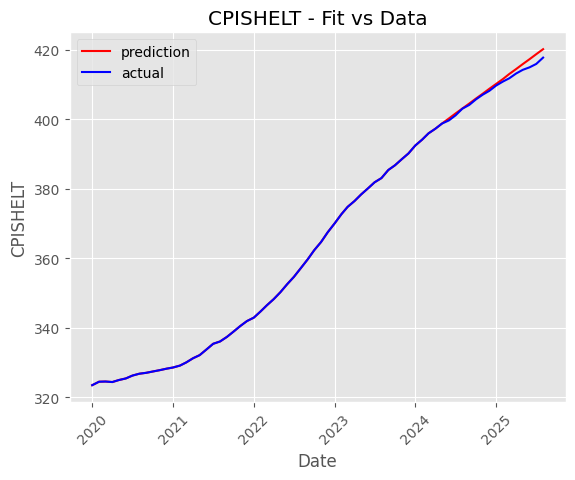

In [227]:
plt.plot(pred_df_rec['observation_date'], pred_df_rec['pred_cpi'], label='prediction', color='red')
plt.plot(cpih_rec['observation_date'], cpih_rec['CPISHELT'], label='actual', color='blue')
plt.xlabel('Date')
plt.ylabel('CPISHELT')
plt.title('CPISHELT - Fit vs Data')
plt.xticks(rotation=45)
plt.legend();

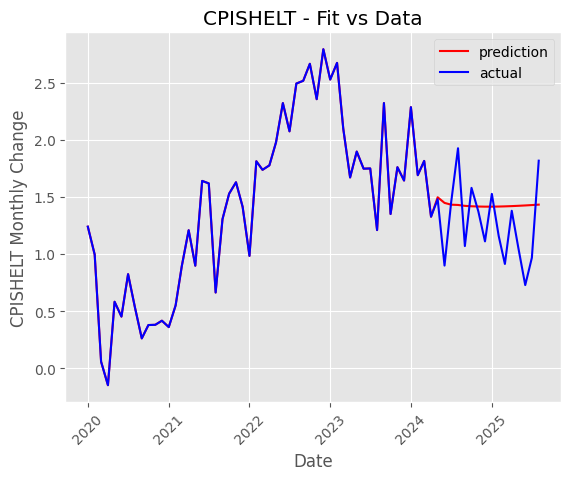

In [228]:
plt.plot(pred_df_rec['observation_date'], pred_df_rec['diffs_real'], label='prediction', color='red')
plt.plot(cpih_rec['observation_date'], cpih_rec['CPISHELT_delta'], label='actual', color='blue')
plt.xlabel('Date')
plt.ylabel('CPISHELT Monthly Change')
plt.title('CPISHELT - Fit vs Data')
plt.xticks(rotation=45)
plt.legend();

### Future Predictions (AR Model)

In [229]:
armod_sm = AutoReg(cpih['CPISHELT_logdelta'][1:].values, lags = p).fit()
print(armod_sm.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  871
Model:                     AutoReg(3)   Log Likelihood                3900.480
Method:               Conditional MLE   S.D. of innovations              0.003
Date:                Sun, 14 Sep 2025   AIC                          -7790.960
Time:                        18:15:22   BIC                          -7767.129
Sample:                             3   HQIC                         -7781.841
                                  871                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      6.793      0.000       0.001       0.001
y.L1           0.3754      0.034     11.101      0.000       0.309       0.442
y.L2           0.2542      0.035      7.258      0.0

In [230]:
# Predictions for future
b = 20
k, n_train = b, cpih['CPISHELT_logdelta'][1:].values.shape[0]
fcast = armod_sm.get_prediction(start = n_train, end = n_train + k - 1)
fcast_mean = fcast.predicted_mean
fcast_mean

array([0.00334806, 0.00353302, 0.00351858, 0.00347335, 0.00346853,
       0.00345399, 0.00344344, 0.00343537, 0.00342841, 0.00342285,
       0.0034183 , 0.00341458, 0.00341155, 0.00340908, 0.00340707,
       0.00340542, 0.00340408, 0.00340299, 0.00340209, 0.00340137])

In [231]:
start_date = '2025-09-01'
periods = b

dates_fut = pd.date_range(start=start_date, periods=periods, freq='MS')
dates_fut

DatetimeIndex(['2025-09-01', '2025-10-01', '2025-11-01', '2025-12-01',
               '2026-01-01', '2026-02-01', '2026-03-01', '2026-04-01',
               '2026-05-01', '2026-06-01', '2026-07-01', '2026-08-01',
               '2026-09-01', '2026-10-01', '2026-11-01', '2026-12-01',
               '2027-01-01', '2027-02-01', '2027-03-01', '2027-04-01'],
              dtype='datetime64[ns]', freq='MS')

In [232]:
diffs_with_pred = np.append(cpih['CPISHELT_logdelta'][1:].values, fcast_mean)
diffs_with_pred.shape

(891,)

In [284]:
pred_df = pd.DataFrame({'observation_date': np.append(cpih['observation_date'][1:].values, dates_fut), 'diffs': diffs_with_pred}).set_index(['observation_date'])
pred_df

,diffs
observation_date,
1953-02-01,0.004598
1953-03-01,0.000000
1953-04-01,0.004577
1953-05-01,0.000000
1953-06-01,0.000000
...,...
2026-12-01,0.003405
2027-01-01,0.003404
2027-02-01,0.003403


In [286]:
base = cpih['CPISHELT_log'].values[0]
pred_df['pred_logcpi'] = pred_df['diffs'].cumsum() + base

In [288]:
pred_df = pred_df.reset_index()
pred_df['pred_cpi'] = np.exp(pred_df['pred_logcpi'])
pred_df['diffs_real'] = pred_df['pred_cpi'].diff().values

In [290]:
pred_df

,observation_date,diffs,pred_logcpi,pred_cpi,diffs_real
0,1953-02-01,0.004598,3.081910,21.800000,NaN
1,1953-03-01,0.000000,3.081910,21.800000,0.000000
2,1953-04-01,0.004577,3.086487,21.900000,0.100000
3,1953-05-01,0.000000,3.086487,21.900000,0.000000
4,1953-06-01,0.000000,3.086487,21.900000,0.000000
...,...,...,...,...,...
886,2026-12-01,0.003405,6.089681,441.280559,1.500191
887,2027-01-01,0.003404,6.093085,442.785274,1.504714
888,2027-02-01,0.003403,6.096488,444.294633,1.509359
889,2027-03-01,0.003402,6.099890,445.808739,1.514107


In [292]:
pred_df_rec = pred_df[pred_df['observation_date'] >= pd.to_datetime('2020-01-01')]

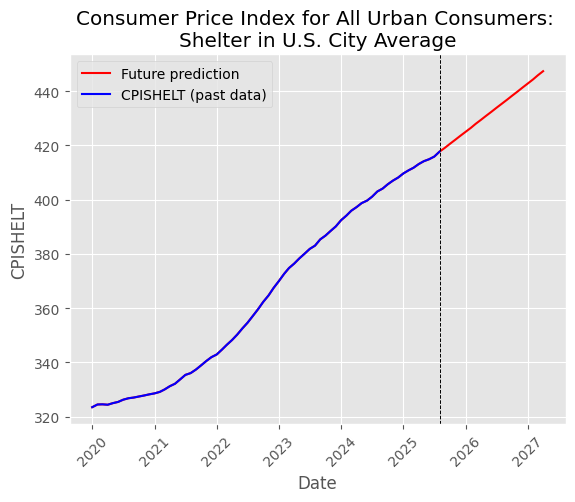

In [298]:
plt.plot(pred_df_rec['observation_date'], pred_df_rec['pred_cpi'], label='Future prediction', color='red')
plt.plot(cpih_rec['observation_date'], cpih_rec['CPISHELT'], label='CPISHELT (past data)', color='blue')
plt.axvline(x=pd.to_datetime('2025-08-01'), color='black', linestyle='--', linewidth=0.7)
plt.xlabel('Date')
plt.ylabel('CPISHELT')
plt.title('Consumer Price Index for All Urban Consumers: \nShelter in U.S. City Average')
plt.xticks(rotation=45)
plt.legend();

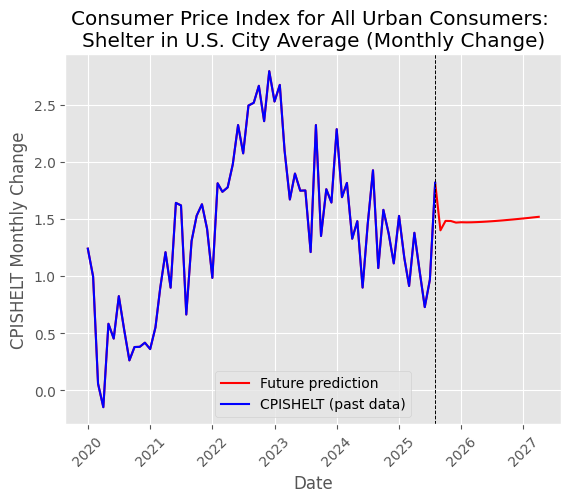

In [300]:
plt.plot(pred_df_rec['observation_date'], pred_df_rec['diffs_real'], label='Future prediction', color='red')
plt.plot(cpih_rec['observation_date'], cpih_rec['CPISHELT_delta'], label='CPISHELT (past data)', color='blue')
plt.axvline(x=pd.to_datetime('2025-08-01'), color='black', linestyle='--', linewidth=0.7)
plt.xlabel('Date')
plt.ylabel('CPISHELT Monthly Change')
plt.title('Consumer Price Index for All Urban Consumers: \nShelter in U.S. City Average (Monthly Change)')
plt.xticks(rotation=45)
plt.legend();

### Fitting ARIMA Model